In [1]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00


# Preprocess

Before you can train a model on a dataset, it needs to be preprocessed into the expected model input format. Whether your data is text, images, or audio, they need to be converted and assembled into batches of tensors. 🤗 Transformers provides a set of preprocessing classes to help prepare your data for the model. In this tutorial, you'll learn that for:

* Text, use a [Tokenizer](https://huggingface.co/docs/transformers/main/en/./main_classes/tokenizer) to convert text into a sequence of tokens, create a numerical representation of the tokens, and assemble them into tensors.
* Speech and audio, use a [Feature extractor](https://huggingface.co/docs/transformers/main/en/./main_classes/feature_extractor) to extract sequential features from audio waveforms and convert them into tensors.
* Image inputs use a [ImageProcessor](https://huggingface.co/docs/transformers/main/en/./main_classes/image) to convert images into tensors.
* Multimodal inputs, use a [Processor](https://huggingface.co/docs/transformers/main/en/./main_classes/processors) to combine a tokenizer and a feature extractor or image processor.

<Tip>

`AutoProcessor` **always** works and automatically chooses the correct class for the model you're using, whether you're using a tokenizer, image processor, feature extractor or processor.

</Tip>

Before you begin, install 🤗 Datasets so you can load some datasets to experiment with:

```bash
pip install datasets
```

## Natural Language Processing

In [2]:
#@title
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/Yffk5aydLzg?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


The main tool for preprocessing textual data is a [tokenizer](https://huggingface.co/docs/transformers/main/en/main_classes/tokenizer). A tokenizer splits text into *tokens* according to a set of rules. The tokens are converted into numbers and then tensors, which become the model inputs. Any additional inputs required by the model are added by the tokenizer.

<Tip>

If you plan on using a pretrained model, it's important to use the associated pretrained tokenizer. This ensures the text is split the same way as the pretraining corpus, and uses the same corresponding tokens-to-index (usually referred to as the *vocab*) during pretraining.

</Tip>

Get started by loading a pretrained tokenizer with the [AutoTokenizer.from_pretrained()](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoTokenizer.from_pretrained) method. This downloads the *vocab* a model was pretrained with:

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Then pass your text to the tokenizer:

In [4]:
encoded_input = tokenizer("Do not meddle in the affairs of wizards, for they are subtle and quick to anger.")
print(encoded_input)

{'input_ids': [101, 2091, 1136, 1143, 13002, 1107, 1103, 5707, 1104, 16678, 1116, 117, 1111, 1152, 1132, 11515, 1105, 3613, 1106, 4470, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


The tokenizer returns a dictionary with three important items:

* [input_ids](https://huggingface.co/docs/transformers/main/en/glossary#input-ids) are the indices corresponding to each token in the sentence.
* [attention_mask](https://huggingface.co/docs/transformers/main/en/glossary#attention-mask) indicates whether a token should be attended to or not.
* [token_type_ids](https://huggingface.co/docs/transformers/main/en/glossary#token-type-ids) identifies which sequence a token belongs to when there is more than one sequence.

Return your input by decoding the `input_ids`:

In [5]:
tokenizer.decode(encoded_input["input_ids"])

'[CLS] Do not meddle in the affairs of wizards, for they are subtle and quick to anger. [SEP]'

As you can see, the tokenizer added two special tokens - `CLS` and `SEP` (classifier and separator) - to the sentence. Not all models need
special tokens, but if they do, the tokenizer automatically adds them for you.

If there are several sentences you want to preprocess, pass them as a list to the tokenizer:

In [6]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_inputs = tokenizer(batch_sentences)
print(encoded_inputs)

{'input_ids': [[101, 1252, 1184, 1164, 1248, 6462, 136, 102], [101, 1790, 112, 189, 1341, 1119, 3520, 1164, 1248, 6462, 117, 21902, 1643, 119, 102], [101, 1327, 1164, 5450, 23434, 136, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}


In [7]:
from transformers import AutoTokenizer

# Load a pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize input text
input_text = "Transformers make NLP tasks easier."
tokens = tokenizer(input_text, return_tensors="pt")

# Print the tokens and corresponding input_ids
print("Tokens:", tokenizer.convert_ids_to_tokens(tokens["input_ids"].tolist()[0]))
print("Input IDs:", tokens["input_ids"])


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokens: ['[CLS]', 'transformers', 'make', 'nl', '##p', 'tasks', 'easier', '.', '[SEP]']
Input IDs: tensor([[  101, 19081,  2191, 17953,  2361,  8518,  6082,  1012,   102]])


### Pad

Sentences aren't always the same length which can be an issue because tensors, the model inputs, need to have a uniform shape. Padding is a strategy for ensuring tensors are rectangular by adding a special *padding token* to shorter sentences.

Set the `padding` parameter to `True` to pad the shorter sequences in the batch to match the longest sequence:

In [8]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch_sentences, padding=True)
print(encoded_input)

{'input_ids': [[101, 2021, 2054, 2055, 2117, 6350, 1029, 102, 0, 0, 0, 0, 0, 0], [101, 2123, 1005, 1056, 2228, 2002, 4282, 2055, 2117, 6350, 1010, 28315, 1012, 102], [101, 2054, 2055, 5408, 14625, 1029, 102, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]]}


In [9]:
from transformers import BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Instantiate a BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize and encode the sentences
sentences = ["This is a sample sentence.", "Another example for illustration."]
encoded_sentences = [tokenizer.encode(sentence, add_special_tokens=True) for sentence in sentences]

# Pad sequences to the same length
padded_sequences = pad_sequences(encoded_sentences, padding='post', truncating='post')

# Print the results
print("Original Sentences:", sentences)
print("Padded Sequences:\n", padded_sequences)


Original Sentences: ['This is a sample sentence.', 'Another example for illustration.']
Padded Sequences:
 [[  101  2023  2003  1037  7099  6251  1012   102]
 [  101  2178  2742  2005 14614  1012   102     0]]


The first and third sentences are now padded with `0`'s because they are shorter.

### Truncation

On the other end of the spectrum, sometimes a sequence may be too long for a model to handle. In this case, you'll need to truncate the sequence to a shorter length.

Set the `truncation` parameter to `True` to truncate a sequence to the maximum length accepted by the model:

In [10]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch_sentences, padding=True, truncation=True)
print(encoded_input)

{'input_ids': [[101, 2021, 2054, 2055, 2117, 6350, 1029, 102, 0, 0, 0, 0, 0, 0], [101, 2123, 1005, 1056, 2228, 2002, 4282, 2055, 2117, 6350, 1010, 28315, 1012, 102], [101, 2054, 2055, 5408, 14625, 1029, 102, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]]}


<Tip>

Check out the [Padding and truncation](https://huggingface.co/docs/transformers/main/en/./pad_truncation) concept guide to learn more different padding and truncation arguments.

</Tip>

In [11]:
from transformers import BertTokenizer

# Instantiate a BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize and truncate the sentences
sentences = ["This is a sample sentence that needs truncation.", "Another example for illustration."]
truncated_sequences = [tokenizer.encode(sentence, max_length=10, truncation=True) for sentence in sentences]

# Print the results
print("Original Sentences:", sentences)
print("Truncated Sequences:\n", truncated_sequences)


Original Sentences: ['This is a sample sentence that needs truncation.', 'Another example for illustration.']
Truncated Sequences:
 [[101, 2023, 2003, 1037, 7099, 6251, 2008, 3791, 19817, 102], [101, 2178, 2742, 2005, 14614, 1012, 102]]


### Build tensors

Finally, you want the tokenizer to return the actual tensors that get fed to the model.

Set the `return_tensors` parameter to either `pt` for PyTorch, or `tf` for TensorFlow:

In [12]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt")
print(encoded_input)

{'input_ids': tensor([[  101,  2021,  2054,  2055,  2117,  6350,  1029,   102,     0,     0,
             0,     0,     0,     0],
        [  101,  2123,  1005,  1056,  2228,  2002,  4282,  2055,  2117,  6350,
          1010, 28315,  1012,   102],
        [  101,  2054,  2055,  5408, 14625,  1029,   102,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])}


In [13]:
from transformers import AutoTokenizer

# Load pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize and convert to tensors
inputs = tokenizer("Example text for tokenization", return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  2742,  3793,  2005, 19204,  3989,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


## Audio

For audio tasks, you'll need a [feature extractor](https://huggingface.co/docs/transformers/main/en/main_classes/feature_extractor) to prepare your dataset for the model. The feature extractor is designed to extract features from raw audio data, and convert them into tensors.

Load the [MInDS-14](https://huggingface.co/datasets/PolyAI/minds14) dataset (see the 🤗 [Datasets tutorial](https://huggingface.co/docs/datasets/load_hub.html) for more details on how to load a dataset) to see how you can use a feature extractor with audio datasets:

In [14]:
from datasets import load_dataset, Audio

dataset = load_dataset("PolyAI/minds14", name="en-US", split="train")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Access the first element of the `audio` column to take a look at the input. Calling the `audio` column automatically loads and resamples the audio file:

In [15]:
dataset[0]["audio"]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/28aa727f91fee90575c34956bab09d1716cfaf460c6afcba86a10f04a7d58b83/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav',
 'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
         0.        ,  0.        ]),
 'sampling_rate': 8000}

This returns three items:

* `array` is the speech signal loaded - and potentially resampled - as a 1D array.
* `path` points to the location of the audio file.
* `sampling_rate` refers to how many data points in the speech signal are measured per second.

For this tutorial, you'll use the [Wav2Vec2](https://huggingface.co/facebook/wav2vec2-base) model. Take a look at the model card, and you'll learn Wav2Vec2 is pretrained on 16kHz sampled speech audio. It is important your audio data's sampling rate matches the sampling rate of the dataset used to pretrain the model. If your data's sampling rate isn't the same, then you need to resample your data.

1. Use 🤗 Datasets' [cast_column](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.cast_column) method to upsample the sampling rate to 16kHz:

In [16]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))

2. Call the `audio` column again to resample the audio file:

In [17]:
dataset[0]["audio"]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/28aa727f91fee90575c34956bab09d1716cfaf460c6afcba86a10f04a7d58b83/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav',
 'array': array([ 1.70562416e-05,  2.18727451e-04,  2.28099874e-04, ...,
         3.43842403e-05, -5.96364771e-06, -1.76846661e-05]),
 'sampling_rate': 16000}

Next, load a feature extractor to normalize and pad the input. When padding textual data, a `0` is added for shorter sequences. The same idea applies to audio data. The feature extractor adds a `0` - interpreted as silence - to `array`.

Load the feature extractor with [AutoFeatureExtractor.from_pretrained()](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoFeatureExtractor.from_pretrained):

In [18]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Pass the audio `array` to the feature extractor. We also recommend adding the `sampling_rate` argument in the feature extractor in order to better debug any silent errors that may occur.

In [19]:
audio_input = [dataset[0]["audio"]["array"]]
feature_extractor(audio_input, sampling_rate=16000)

{'input_values': [array([ 3.0293269e-04,  2.7676334e-03,  2.8821775e-03, ...,
        5.1470479e-04,  2.1597825e-05, -1.2164921e-04], dtype=float32)]}

Just like the tokenizer, you can apply padding or truncation to handle variable sequences in a batch. Take a look at the sequence length of these two audio samples:

In [20]:
dataset[0]["audio"]["array"].shape

(173398,)

In [21]:
dataset[1]["audio"]["array"].shape

(106496,)

Create a function to preprocess the dataset so the audio samples are the same lengths. Specify a maximum sample length, and the feature extractor will either pad or truncate the sequences to match it:

In [22]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=16000,
        padding=True,
        max_length=100000,
        truncation=True,
    )
    return inputs

Apply the `preprocess_function` to the the first few examples in the dataset:

In [23]:
processed_dataset = preprocess_function(dataset[:5])

The sample lengths are now the same and match the specified maximum length. You can pass your processed dataset to the model now!

In [24]:
processed_dataset["input_values"][0].shape

(100000,)

In [25]:
processed_dataset["input_values"][1].shape

(100000,)

In [29]:
dataset = load_dataset("PolyAI/minds14", name="en-US", split="train")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [30]:
dataset[2]["audio"]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/28aa727f91fee90575c34956bab09d1716cfaf460c6afcba86a10f04a7d58b83/en-US~JOINT_ACCOUNT/602b9f97963e11ccd901cc32.wav',
 'array': array([0.        , 0.        , 0.        , ..., 0.00073242, 0.00048828,
        0.00097656]),
 'sampling_rate': 8000}

In [31]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))

In [32]:
dataset[0]["audio"]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/28aa727f91fee90575c34956bab09d1716cfaf460c6afcba86a10f04a7d58b83/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav',
 'array': array([ 1.70562416e-05,  2.18727451e-04,  2.28099874e-04, ...,
         3.43842403e-05, -5.96364771e-06, -1.76846661e-05]),
 'sampling_rate': 16000}

In [33]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/w2v-bert-2.0")

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

In [34]:
audio_input = [dataset[0]["audio"]["array"]]
feature_extractor(audio_input, sampling_rate=16000)

{'input_features': array([[[-1.2093762 , -1.1922928 , -1.3441527 , ..., -1.2544124 ,
         -1.2508634 , -1.2674514 ],
        [-1.5043353 , -1.355277  , -1.1916454 , ..., -0.6493121 ,
         -0.64878404, -0.6664241 ],
        [-1.0062762 , -0.7734515 , -0.640627  , ..., -0.99292755,
         -0.9837499 , -0.99497783],
        ...,
        [-1.7612292 , -1.5347452 , -1.2533092 , ..., -1.2507983 ,
         -1.264615  , -1.2895837 ],
        [-1.2119894 , -1.2545875 , -1.491147  , ..., -1.0333458 ,
         -1.0231705 , -1.0314765 ],
        [-1.1942915 , -1.4836422 , -1.3493654 , ..., -1.1923531 ,
         -1.1782926 , -1.184726  ]]], dtype=float32), 'attention_mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1

In [35]:
dataset[0]["audio"]["array"].shape

(173398,)

In [36]:
dataset[1]["audio"]["array"].shape

(106496,)

## Computer vision

For computer vision tasks, you'll need an [image processor](https://huggingface.co/docs/transformers/main/en/main_classes/image_processor) to prepare your dataset for the model.
Image preprocessing consists of several steps that convert images into the input expected by the model. These steps
include but are not limited to resizing, normalizing, color channel correction, and converting images to tensors.

<Tip>

Image preprocessing often follows some form of image augmentation. Both image preprocessing and image augmentation
transform image data, but they serve different purposes:

* Image augmentation alters images in a way that can help prevent overfitting and increase the robustness of the model. You can get creative in how you augment your data - adjust brightness and colors, crop, rotate, resize, zoom, etc. However, be mindful not to change the meaning of the images with your augmentations.
* Image preprocessing guarantees that the images match the model’s expected input format. When fine-tuning a computer vision model, images must be preprocessed exactly as when the model was initially trained.

You can use any library you like for image augmentation. For image preprocessing, use the `ImageProcessor` associated with the model.

</Tip>

Load the [food101](https://huggingface.co/datasets/food101) dataset (see the 🤗 [Datasets tutorial](https://huggingface.co/docs/datasets/load_hub.html) for more details on how to load a dataset) to see how you can use an image processor with computer vision datasets:

<Tip>

Use 🤗 Datasets `split` parameter to only load a small sample from the training split since the dataset is quite large!

</Tip>

In [37]:
from datasets import load_dataset

dataset = load_dataset("food101", split="train[:100]")

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Next, take a look at the image with 🤗 Datasets [`Image`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=image#datasets.Image) feature:

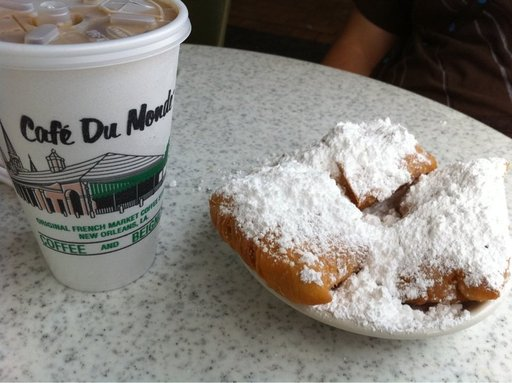

In [38]:
dataset[2]["image"]

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/vision-preprocess-tutorial.png"/>
</div>

Load the image processor with [AutoImageProcessor.from_pretrained()](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoImageProcessor.from_pretrained):

In [39]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

First, let's add some image augmentation. You can use any library you prefer, but in this tutorial, we'll use torchvision's [`transforms`](https://pytorch.org/vision/stable/transforms.html) module. If you're interested in using another data augmentation library, learn how in the [Albumentations](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_classification_albumentations.ipynb) or [Kornia notebooks](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_classification_kornia.ipynb).

1. Here we use [`Compose`](https://pytorch.org/vision/master/generated/torchvision.transforms.Compose.html) to chain together a couple of
transforms - [`RandomResizedCrop`](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html) and [`ColorJitter`](https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html).
Note that for resizing, we can get the image size requirements from the `image_processor`. For some models, an exact height and
width are expected, for others only the `shortest_edge` is defined.

In [40]:
from torchvision.transforms import RandomResizedCrop, ColorJitter, Compose

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

_transforms = Compose([RandomResizedCrop(size), ColorJitter(brightness=0.5, hue=0.5)])

2. The model accepts [`pixel_values`](https://huggingface.co/docs/transformers/main/en/model_doc/visionencoderdecoder#transformers.VisionEncoderDecoderModel.forward.pixel_values)
as its input. `ImageProcessor` can take care of normalizing the images, and generating appropriate tensors.
Create a function that combines image augmentation and image preprocessing for a batch of images and generates `pixel_values`:

In [41]:
def transforms(examples):
    images = [_transforms(img.convert("RGB")) for img in examples["image"]]
    examples["pixel_values"] = image_processor(images, do_resize=False, return_tensors="pt")["pixel_values"]
    return examples

<Tip>

In the example above we set `do_resize=False` because we have already resized the images in the image augmentation transformation,
and leveraged the `size` attribute from the appropriate `image_processor`. If you do not resize images during image augmentation,
leave this parameter out. By default, `ImageProcessor` will handle the resizing.

If you wish to normalize images as a part of the augmentation transformation, use the `image_processor.image_mean`,
and `image_processor.image_std` values.
</Tip>

3. Then use 🤗 Datasets [`set_transform`](https://huggingface.co/docs/datasets/process.html#format-transform) to apply the transforms on the fly:

In [42]:
dataset.set_transform(transforms)

4. Now when you access the image, you'll notice the image processor has added `pixel_values`. You can pass your processed dataset to the model now!

In [43]:
dataset[0].keys()

dict_keys(['image', 'label', 'pixel_values'])

Here is what the image looks like after the transforms are applied. The image has been randomly cropped and it's color properties are different.

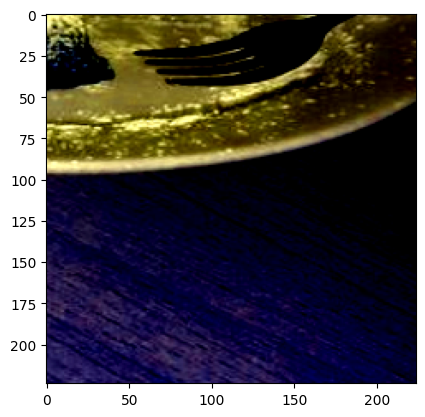

In [44]:
import numpy as np
import matplotlib.pyplot as plt

img = dataset[0]["pixel_values"]
plt.imshow(img.permute(1, 2, 0))

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/preprocessed_image.png"/>
</div>

<Tip>

For tasks like object detection, semantic segmentation, instance segmentation, and panoptic segmentation, `ImageProcessor`
offers post processing methods. These methods convert model's raw outputs into meaningful predictions such as bounding boxes,
or segmentation maps.

</Tip>

In [45]:
from datasets import load_dataset

dataset = load_dataset("rajistics/indian_food_images", split="train[:100]")

Generating train split:   0%|          | 0/5328 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/941 [00:00<?, ? examples/s]

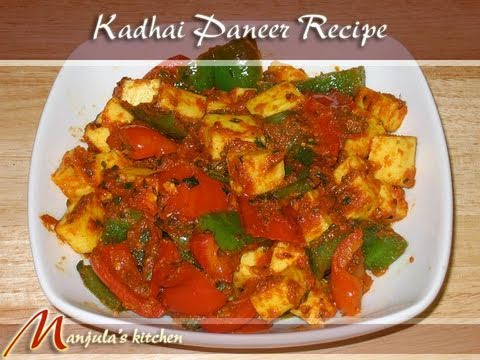

In [46]:
dataset[2]["image"]

In [47]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

In [48]:
from torchvision.transforms import RandomResizedCrop, ColorJitter, Compose

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

_transforms = Compose([RandomResizedCrop(size), ColorJitter(brightness=0.5, hue=0.5)])

In [49]:
def transforms(examples):
    images = [_transforms(img.convert("RGB")) for img in examples["image"]]
    examples["pixel_values"] = image_processor(images, do_resize=False, return_tensors="pt")["pixel_values"]
    return examples

In [50]:
dataset.set_transform(transforms)

In [51]:
dataset[0].keys()

dict_keys(['image', 'label', 'pixel_values'])

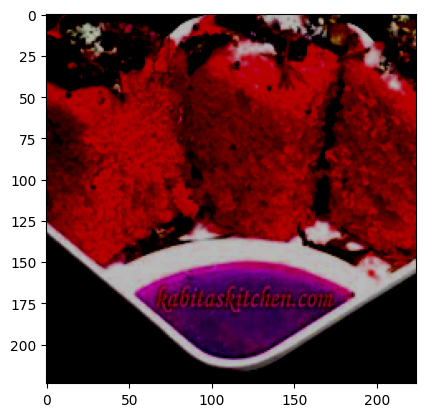

In [52]:
import numpy as np
import matplotlib.pyplot as plt

img = dataset[0]["pixel_values"]
plt.imshow(img.permute(1, 2, 0))

### Pad

In some cases, for instance, when fine-tuning [DETR](https://huggingface.co/docs/transformers/main/en/./model_doc/detr), the model applies scale augmentation at training
time. This may cause images to be different sizes in a batch. You can use [DetrImageProcessor.pad_and_create_pixel_mask()](https://huggingface.co/docs/transformers/main/en/model_doc/detr#transformers.DetrFeatureExtractor.pad_and_create_pixel_mask)
from [DetrImageProcessor](https://huggingface.co/docs/transformers/main/en/model_doc/detr#transformers.DetrImageProcessor) and define a custom `collate_fn` to batch images together.

In [53]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

## Multimodal

For tasks involving multimodal inputs, you'll need a [processor](https://huggingface.co/docs/transformers/main/en/main_classes/processors) to prepare your dataset for the model. A processor couples together two processing objects such as as tokenizer and feature extractor.

Load the [LJ Speech](https://huggingface.co/datasets/lj_speech) dataset (see the 🤗 [Datasets tutorial](https://huggingface.co/docs/datasets/load_hub.html) for more details on how to load a dataset) to see how you can use a processor for automatic speech recognition (ASR):

In [54]:
from datasets import load_dataset

lj_speech = load_dataset("lj_speech", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

For ASR, you're mainly focused on `audio` and `text` so you can remove the other columns:

In [55]:
lj_speech = lj_speech.map(remove_columns=["file", "id", "normalized_text"])

Map:   0%|          | 0/13100 [00:00<?, ? examples/s]

Now take a look at the `audio` and `text` columns:

In [ ]:
lj_speech[0]["audio"]

In [57]:
lj_speech[0]["text"]

'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'

Remember you should always [resample](https://huggingface.co/docs/transformers/main/en/preprocessing#audio) your audio dataset's sampling rate to match the sampling rate of the dataset used to pretrain a model!

In [58]:
lj_speech = lj_speech.cast_column("audio", Audio(sampling_rate=16_000))

Load a processor with [AutoProcessor.from_pretrained()](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoProcessor.from_pretrained):

In [59]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

1. Create a function to process the audio data contained in `array` to `input_values`, and tokenize `text` to `labels`. These are the inputs to the model:

In [60]:
def prepare_dataset(example):
    audio = example["audio"]

    example.update(processor(audio=audio["array"], text=example["text"], sampling_rate=16000))

    return example

2. Apply the `prepare_dataset` function to a sample:

In [61]:
prepare_dataset(lj_speech[0])

{'audio': {'path': 'LJ001-0001.wav',
  'array': array([-0.00061751, -0.00074496, -0.00068972, ...,  0.00068615,
          0.00013802,  0.        ]),
  'sampling_rate': 16000},
 'text': 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition',
 'input_values': [array([-6.4672441e-03, -7.7975024e-03, -7.2209686e-03, ...,
          7.1398341e-03,  1.4186004e-03, -2.1961636e-05], dtype=float32)],
 'labels': [23,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  4,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  4,
  3,
  3,
  3,
  4,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  4,
  3,
  3,
  4,
  3,
  3,
  3,
  4,
  3,
  3,
  3,
  3,
  4,
  3,
 

The processor has now added `input_values` and `labels`, and the sampling rate has also been correctly downsampled to 16kHz. You can pass your processed dataset to the model now!